In [1]:
import os
import datetime
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/rl_sim/TactileDriven_Arto/UTILITIES')

from Performance_plotter import plot_f1_score_threshold, plot_precision_recall_curve, plot_confusion_matrix, plot_roc_curve
from ML_models_functions import to_save_model, free_gpu_memory, save_datasummary_and_results
from XAI_FCN import plot_grad_cam

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from scipy.signal import butter, filtfilt
import traceback

import tensorflow
gpus = tensorflow.config.list_physical_devices('GPU')
# if gpus:    
#     for gpu in gpus:
#         tensorflow.config.set_logical_device_configuration(
#             gpu,
#             [tensorflow.config.LogicalDeviceConfiguration(memory_limit=4*1024)])  # Adjust memory limit as needed


import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)
# Set GPU 1 (the second GPU) to be the only visible device
# if gpus:
#     try:
#         tf.config.set_visible_devices(gpus[1], 'GPU')
        
#         # Optionally, set memory growth to avoid allocating all memory on the GPU at once
#         tf.config.experimental.set_memory_growth(gpus[1], True)
#     except RuntimeError as e:
#         print(e)


from tensorflow.keras.models     import Sequential, Model, load_model
from tensorflow.keras.layers     import Input, Conv1D, Conv2D, BatchNormalization
from tensorflow.keras.layers     import Flatten, Dense, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D, GlobalMaxPooling2D
from tensorflow.keras.layers     import LeakyReLU, ReLU, Activation, Dropout, Lambda
from tensorflow.keras.layers     import concatenate, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses     import BinaryCrossentropy
from tensorflow.keras.metrics    import AUC
from tensorflow.keras.callbacks  import EarlyStopping

from tensorflow.keras.utils      import plot_model

def load_data(data_folder):
    X_data = []
    y_data = []
    
    # Traverse the data folder
    for file in os.listdir(data_folder):
        if file.endswith(".npz"):
            file_path = os.path.join(data_folder, file)
            data = np.load(file_path)
            X_data.append(data['X'])
            y_data.append(data['y'])
    
    # Stack the data into arrays
    X_data = np.vstack(X_data)
    y_data = np.hstack(y_data)
    
    return X_data, y_data


data_folder = '/home/rl_sim/TactileDriven_Arto/ML_Actions/DATA/1D_TRANSF_SPEED_FTP_ScalNorm'

X_data, y_data = load_data(data_folder)

# Check the shape of loaded data
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)
print("X_data.[0] shape: ", X_data[0].shape)
print("y_data.[0] max: ", np.max(y_data))

TEST_SIZE = 0.4
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"TOTAL DATA: {len(X_data)}  ||  Train = {100*(1-TEST_SIZE)}%  ||  Test = {100*TEST_SIZE}%")
print("Dimensions of X_train:", X_train.shape, "   ||  Dimensions of y_train:", y_train.shape)
print("Dimensions of X_test: ", X_test.shape, "   ||  Dimensions of y_test: ", y_test.shape)
print("Dimensions of X_val:  ", X_val.shape, "   ||  Dimensions of y_val:  ", y_val.shape)

data_dict = {
    "X_train": X_train,
    "X_val": X_val,
    "X_test": X_test
}

def assign_and_deploy_variables(data_dict):
    for key, data in data_dict.items():
        globals()[f"{key}1"] = data[:, :, 1]
        globals()[f"{key}2"] = data[:, :, 5]
        globals()[f"{key}3"] = np.dstack((data[:, :, 2], data[:, :, 4]))
        globals()[f"{key}4"] = np.dstack((data[:, :, 6], data[:, :, 8]))

# Example usage
assign_and_deploy_variables(data_dict)

# Printing shapes
print("Shapes of the stacked arrays:")
print("X_train1 shape:", X_train1.shape)
print("X_train2 shape:", X_train2.shape)
print("X_train3 shape:", X_train3.shape)
print("X_train4 shape:", X_train4.shape)

import tensorflow as tf

WS_B = 1800  # Example sequence length
input_shape1 = (WS_B, 1)
input_shape2 = (WS_B, 1)
input_shape3 = (WS_B, 2)
input_shape4 = (WS_B, 2)

OUT_N = int(np.max(y_data)) + 1  # Plus one because labels are typically zero-indexed
DISP_LABELS = list(range(OUT_N))  # Generate labels from 0 to OUT_N-1
print("OUT_N:", OUT_N)
print("DISP_LABELS:", DISP_LABELS)

def compile_train_evaluate_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=50, batch_size=32, patience=8, disp_labels=DISP_LABELS):
    # Compile the model
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)

    # Predict labels for test data
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Plot training history
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    # Plot Loss Value
    axs[0].plot(history.history["loss"], label="loss (Training)")
    axs[0].plot(history.history["val_loss"], label="val_loss")
    axs[0].set_title("Loss Value")
    axs[0].set_xlabel('Epoch')
    axs[0].legend()

    # Plot Accuracy
    axs[1].plot(history.history["accuracy"], label="accuracy")
    axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
    axs[1].set_title("Accuracy")
    axs[1].set_xlabel('Epoch')
    axs[1].legend()
    plt.tight_layout()
    plt.show()

    # Calculate additional metrics
    f1 = f1_score(y_test, y_pred_labels, average='macro') 
    accuracy = accuracy_score(y_test, y_pred_labels)

    print("Test loss:", loss)
    print("Test accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Classification Report:\n", classification_report(y_test, y_pred_labels))

    # Confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=disp_labels)
    disp.plot(cmap=plt.cm.viridis)  # You can adjust the colormap as needed
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    return history, loss, accuracy, f1, y_pred_labels

2024-10-29 20:42:08.519968: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-29 20:42:08.548253: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-29 20:42:08.982369: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
X_data shape: (465, 1800, 9)
y_data shape: (465,)
X_data.[0] shape:  (1800, 9)
y_data.[0] max:  3.0
TOTAL DATA: 465  ||  Train = 60.0%  ||  Test = 40.0%
Dimensions of X_train: (279, 1800, 9)    ||  Dimensions of y_train: (279,)
Dimensions of X_test:  (93, 1800, 9)    ||  Dimensions of y_test:  (93,)
Dimensions of X_val:   (93, 1800, 9)    ||  Dimensions of y_val:   (93,)
Shapes of the stacked arrays:
X_train1 shape: (279, 1800)
X_train2 shape: (279, 1800)
X_train3 shape: (279, 1800, 2)
X_train4 shape: (279, 1800, 2)
OUT_N: 4
DISP_LABELS: [0, 1, 2, 3]


2024-10-29 20:42:09.313918: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-29 20:42:09.314091: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-29 20:42:09.340929: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

2024-10-29 20:38:38.768043: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-29 20:38:38.768207: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-29 20:38:38.768329: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "TwoBranchModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_1D (InputLayer)           │ (None, 1800, 9)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_1D (Conv1D)               │ (None, 177, 64)        │        23,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 177, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 88, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1D (Conv1D)               │ (None, 21, 128)        │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1D (Conv1D)               │ (None, 19, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 19, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 163,076 (637.02 KB)

 Trainable params: 163,076 (637.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70


I0000 00:00:1730230719.768638 1687040 service.cc:145] XLA service 0x7fe104004320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730230719.768665 1687040 service.cc:153]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
I0000 00:00:1730230719.768669 1687040 service.cc:153]   StreamExecutor device (1): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2024-10-29 20:38:39.800556: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-29 20:38:39.888866: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


1/9 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.1250 - loss: 1.6475

I0000 00:00:1730230720.776378 1687040 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - accuracy: 0.2393 - loss: 1.4285 - val_accuracy: 0.4301 - val_loss: 1.1689
Epoch 2/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5183 - loss: 1.0272 - val_accuracy: 0.6882 - val_loss: 0.6769
Epoch 3/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7447 - loss: 0.5915 - val_accuracy: 0.8387 - val_loss: 0.4619
Epoch 4/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8080 - loss: 0.4907 - val_accuracy: 0.8172 - val_loss: 0.5598
Epoch 5/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8168 - loss: 0.4618 - val_accuracy: 0.8065 - val_loss: 0.5112
Epoch 6/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7544 - loss: 0.6128 - val_accuracy: 0.8602 - val_loss: 0.3766
Epoch 7/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8667 - loss: 0.3442 - val_accuracy: 0.8817 - val_loss: 0.2697
Epoch 8/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8482 - loss: 0.3365 - val_accuracy: 0.8172 - val_loss: 0.3641
Epoch 9/70
9/9 ━━

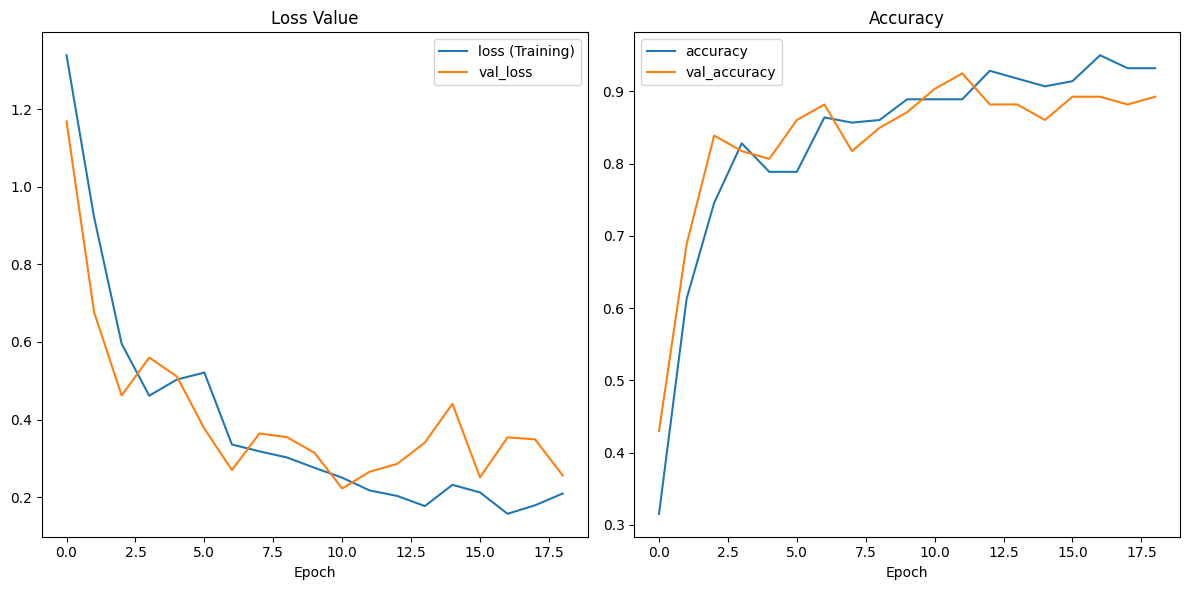

Test loss: 0.18211250007152557
Test accuracy: 0.946236559139785
F1 Score: 0.9389215302258781
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        29
         1.0       0.96      1.00      0.98        22
         2.0       0.88      0.95      0.91        22
         3.0       0.94      0.80      0.86        20

    accuracy                           0.95        93
   macro avg       0.94      0.94      0.94        93
weighted avg       0.95      0.95      0.95        93



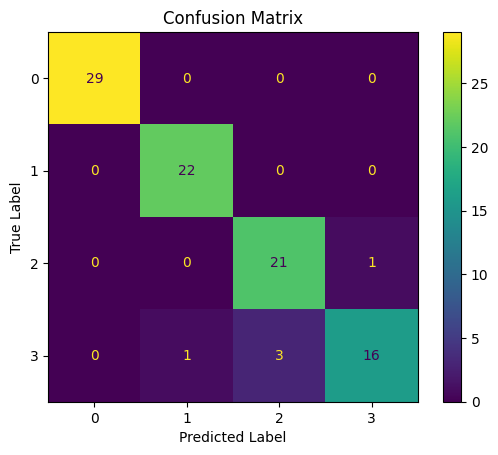

In [2]:
def build_TwoBranchModel(F_input_shape, num_classes):
    # 1D Data Branch
    input_1D = tf.keras.layers.Input(shape=F_input_shape, name='input_1D')
    conv1_1D = tf.keras.layers.Conv1D(64, kernel_size=40, strides=10, name='conv1_1D')(input_1D)
    conv1_1D = tf.keras.layers.Activation('relu')(conv1_1D)
    pool1_1D = tf.keras.layers.MaxPooling1D(pool_size=2)(conv1_1D)

    conv2_1D = tf.keras.layers.Conv1D(128, kernel_size=8, strides=4, name='conv2_1D')(pool1_1D)
    conv2_1D = tf.keras.layers.Activation('relu')(conv2_1D)
    #pool2_1D = tf.keras.layers.GlobalMaxPooling1D()(conv2_1D)

    conv3_1D = tf.keras.layers.Conv1D(128, kernel_size=3, strides=1, name='conv3_1D')(conv2_1D)
    conv3_1D = tf.keras.layers.Activation('relu')(conv3_1D)
    pool3_1D = tf.keras.layers.GlobalMaxPooling1D()(conv3_1D)

    #flatten_1D = tf.keras.layers.Flatten()(pool3_1D)

    fc = tf.keras.layers.Dense(128, activation='relu')(pool3_1D)
    fc = tf.keras.layers.Dense(64, activation='relu')(fc)
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(fc)

    # Define the Model
    model = tf.keras.Model(inputs=[input_1D], outputs=output, name='TwoBranchModel')
    return model

F_input_shape = (1800, 9)  # For the 1D branch (force, torque, and pose data)



_X_train = [X_train]
_X_val = [X_val ]
_X_test = [X_test]

# Create and compile the model
model = build_TwoBranchModel(F_input_shape, OUT_N)
model.summary()
history, loss, accuracy, f1, y_pred_labels = compile_train_evaluate_plot(model, _X_train, y_train, _X_val, y_val, _X_test, y_test, epochs=70, batch_size=32, patience=8, disp_labels=DISP_LABELS)


In [2]:

data_folder = '/home/rl_sim/TactileDriven_Arto/ML_Actions/DATA/1D_TRANSF_SPEED_FTP_ScalNorm'

X_data, y_data = load_data(data_folder)

# Check the shape of loaded data
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)
print("X_data.[0] shape: ", X_data[0].shape)
print("y_data.[0] max: ", np.max(y_data))

TEST_SIZE = 0.4
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"TOTAL DATA: {len(X_data)}  ||  Train = {100*(1-TEST_SIZE)}%  ||  Test = {100*TEST_SIZE}%")
print("Dimensions of X_train:", X_train.shape, "   ||  Dimensions of y_train:", y_train.shape)
print("Dimensions of X_test: ", X_test.shape, "   ||  Dimensions of y_test: ", y_test.shape)
print("Dimensions of X_val:  ", X_val.shape, "   ||  Dimensions of y_val:  ", y_val.shape)

data_dict = {
    "X_train": X_train,
    "X_val": X_val,
    "X_test": X_test
}

def assign_and_deploy_variables(data_dict):
    for key, data in data_dict.items():
        globals()[f"{key}1"] = np.dstack((data[:, :, 1], data[:, :, 4]))
        globals()[f"{key}2"] = data[:, :, 1]
        globals()[f"{key}3"] = np.dstack((data[:, :, 2], data[:, :, 5]))
        globals()[f"{key}4"] = np.dstack((data[:, :, 6], data[:, :, 7], data[:, :, 8]))

import tensorflow as tf

WS_B = 1800  # Example sequence length
input_shape1 = (WS_B, 2)
input_shape2 = (WS_B, 1)
input_shape3 = (WS_B, 2)
input_shape4 = (WS_B, 3)

assign_and_deploy_variables(data_dict)

# Printing shapes
print("Shapes of the stacked arrays:")
print("X_train1 shape:", X_train1.shape)
print("X_train2 shape:", X_train2.shape)
print("X_train3 shape:", X_train3.shape)
print("X_train4 shape:", X_train4.shape)

OUT_N = int(np.max(y_data)) + 1  # Plus one because labels are typically zero-indexed
DISP_LABELS = list(range(OUT_N))  # Generate labels from 0 to OUT_N-1
print("OUT_N:", OUT_N)
print("DISP_LABELS:", DISP_LABELS)


X_data shape: (465, 1800, 9)
y_data shape: (465,)
X_data.[0] shape:  (1800, 9)
y_data.[0] max:  3.0
TOTAL DATA: 465  ||  Train = 60.0%  ||  Test = 40.0%
Dimensions of X_train: (279, 1800, 9)    ||  Dimensions of y_train: (279,)
Dimensions of X_test:  (93, 1800, 9)    ||  Dimensions of y_test:  (93,)
Dimensions of X_val:   (93, 1800, 9)    ||  Dimensions of y_val:   (93,)
Shapes of the stacked arrays:
X_train1 shape: (279, 1800, 2)
X_train2 shape: (279, 1800)
X_train3 shape: (279, 1800, 2)
X_train4 shape: (279, 1800, 3)
OUT_N: 4
DISP_LABELS: [0, 1, 2, 3]


# 2 CONV like EASY_F+F

2024-10-29 20:42:21.477609: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-29 20:42:21.477767: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-29 20:42:21.477886: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 1800, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input2 (InputLayer) │ (None, 1800, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input3 (InputLayer) │ (None, 1800, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input4 (InputLayer) │ (None, 1800, 3)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_1 (Conv1D) │ (None, 180, 128)  │     10,368 │ input1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_1 (Conv1D) │ (None, 180, 128)  │      5,248 │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_1 (Conv1D) │ (None, 180, 128)  │     10,368 │ input3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_1 (Conv1D) │ (None, 180, 128)  │     15,488 │ input4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_2 (Conv1D) │ (None, 89, 256)   │    131,328 │ conv1d_1_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_2 (Conv1D) │ (None, 89, 256)   │    131,328 │ conv1d_2_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_2 (Conv1D) │ (None, 89, 256)   │    131,328 │ conv1d_3_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_2 (Conv1D) │ (None, 89, 256)   │    131,328 │ conv1d_4_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_1_1           │ (None, 256)       │          0 │ conv1d_1_2[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_2_1           │ (None, 256)       │          0 │ conv1d_2_2[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_3_1           │ (None, 256)       │          0 │ conv1d_3_2[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_4_1           │ (None, 256)       │          0 │ conv1d_4_2[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 256)       │          0 │ gap1d_1_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 256)       │          0 │ gap1d_2_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 256)       │          0 │ gap1d_3_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 256)       │          0 │ gap1d_4_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1024)      │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ flatten_2[0][0],  │
│                     │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 632,644 (2.41 MB)

 Trainable params: 632,644 (2.41 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70


I0000 00:00:1730230942.754889 1708790 service.cc:145] XLA service 0x7f8228025780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730230942.754915 1708790 service.cc:153]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
I0000 00:00:1730230942.754919 1708790 service.cc:153]   StreamExecutor device (1): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2024-10-29 20:42:22.801384: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-29 20:42:22.936104: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


1/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.2188 - loss: 1.4336

I0000 00:00:1730230943.837030 1708790 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.3421 - loss: 1.4364 - val_accuracy: 0.4731 - val_loss: 0.9493
Epoch 2/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6016 - loss: 0.8427 - val_accuracy: 0.8495 - val_loss: 0.5455
Epoch 3/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8144 - loss: 0.5611 - val_accuracy: 0.8602 - val_loss: 0.4711
Epoch 4/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8309 - loss: 0.4290 - val_accuracy: 0.8602 - val_loss: 0.4298
Epoch 5/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8450 - loss: 0.3837 - val_accuracy: 0.8495 - val_loss: 0.4344
Epoch 6/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8646 - loss: 0.3186 - val_accuracy: 0.8172 - val_loss: 0.4946
Epoch 7/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8593 - loss: 0.3345 - val_accuracy: 0.8817 - val_loss: 0.3359
Epoch 8/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8597 - loss: 0.3312 - val_accuracy: 0.8602 - val_loss: 0.4030
Epoch 9/70
9/9 ━━

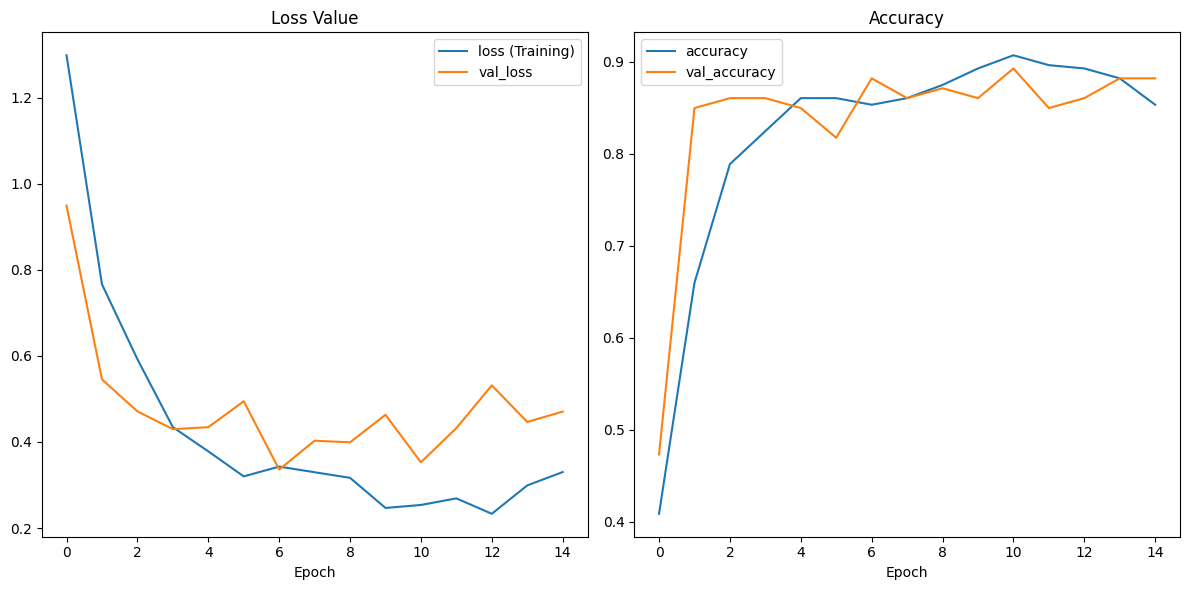

Test loss: 0.2141556292772293
Test accuracy: 0.9032258064516129
F1 Score: 0.8853940512375162
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        29
         1.0       0.81      1.00      0.90        22
         2.0       0.84      0.95      0.89        22
         3.0       1.00      0.60      0.75        20

    accuracy                           0.90        93
   macro avg       0.91      0.89      0.89        93
weighted avg       0.92      0.90      0.90        93



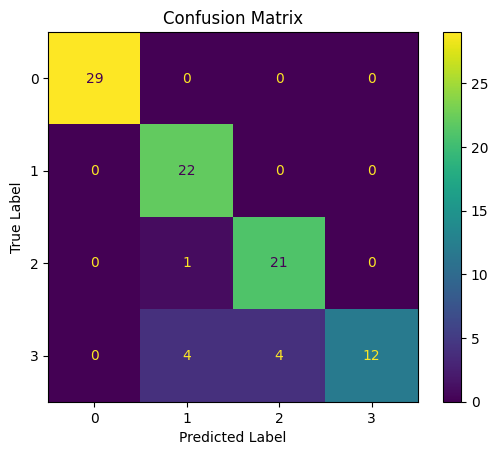

In [3]:
FILTN = 2
def build_branched_model(input_shape1, input_shape2, input_shape3, input_shape4):
    # First input branch
    input1 = Input(shape=input_shape1, name='input1')
    x1 = Conv1D(filters=64*FILTN, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_1_1')(input1)
    x1 = Conv1D(filters=128*FILTN, kernel_size=4, strides=2, activation='relu', name='conv1d_1_2')(x1)
    x1 = GlobalMaxPooling1D(name='gap1d_1_1')(x1)
    x1 = Flatten()(x1)
        # it was GlobalAveragePooling1D
    
    # Second input branch
    input2 = Input(shape=input_shape2, name='input2')
    x2 = Conv1D(filters=64*FILTN, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_2_1')(input2)
    x2 = Conv1D(filters=128*FILTN, kernel_size=4, strides=2, activation='relu', name='conv1d_2_2')(x2)
    x2 = GlobalMaxPooling1D(name='gap1d_2_1')(x2)
    x2 = Flatten()(x2)
    
    # Third input branch
    input3 = Input(shape=input_shape3, name='input3')
    x3 = Conv1D(filters=64*FILTN, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_3_1')(input3)
    x3 = Conv1D(filters=128*FILTN, kernel_size=4, strides=2, activation='relu', name='conv1d_3_2')(x3)
    x3 = GlobalMaxPooling1D(name='gap1d_3_1')(x3)
    x3 = Flatten()(x3)
    
    # Fourth input branch
    input4 = Input(shape=input_shape4, name='input4')
    x4 = Conv1D(filters=64*FILTN, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_4_1')(input4)
    x4 = Conv1D(filters=128*FILTN, kernel_size=4, strides=2, activation='relu', name='conv1d_4_2')(x4)
    x4 = GlobalMaxPooling1D(name='gap1d_4_1')(x4)
    x4 = Flatten()(x4)
    
    # Concatenate the outputs of the four branches
    merged = concatenate([x1, x2, x3, x4], name='concatenate_1')
    
    # Dense layers
    dense = Dense(64, activation='relu', name='dense_1')(merged)
    #dense = Dense(16, activation='relu', name='dense_2')(dense)
    
    # Output layer for 6-class classification
    output = Dense(OUT_N, activation='softmax', name='output')(dense)
    
    model = Model(inputs=[input1, input2, input3, input4], outputs=output)
    return model


# Create and compile the model
model = build_branched_model(input_shape1, input_shape2, input_shape3, input_shape4)
model.summary()

X_train = [X_train1, X_train2, X_train3, X_train4]
X_val   = [X_val1, X_val2, X_val3, X_val4]
X_test  = [X_test1, X_test2, X_test3, X_test4]

history, loss, accuracy, f1, y_pred_labels = compile_train_evaluate_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=70, batch_size=32, patience=8, disp_labels=DISP_LABELS)

In [4]:
# model_name = "1DComb_LDGscal_2Cnv_40krnl_8patienc_1Dns_ConfMatr_99"
# save_datasummary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_branched_model, assign_and_deploy_variables)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


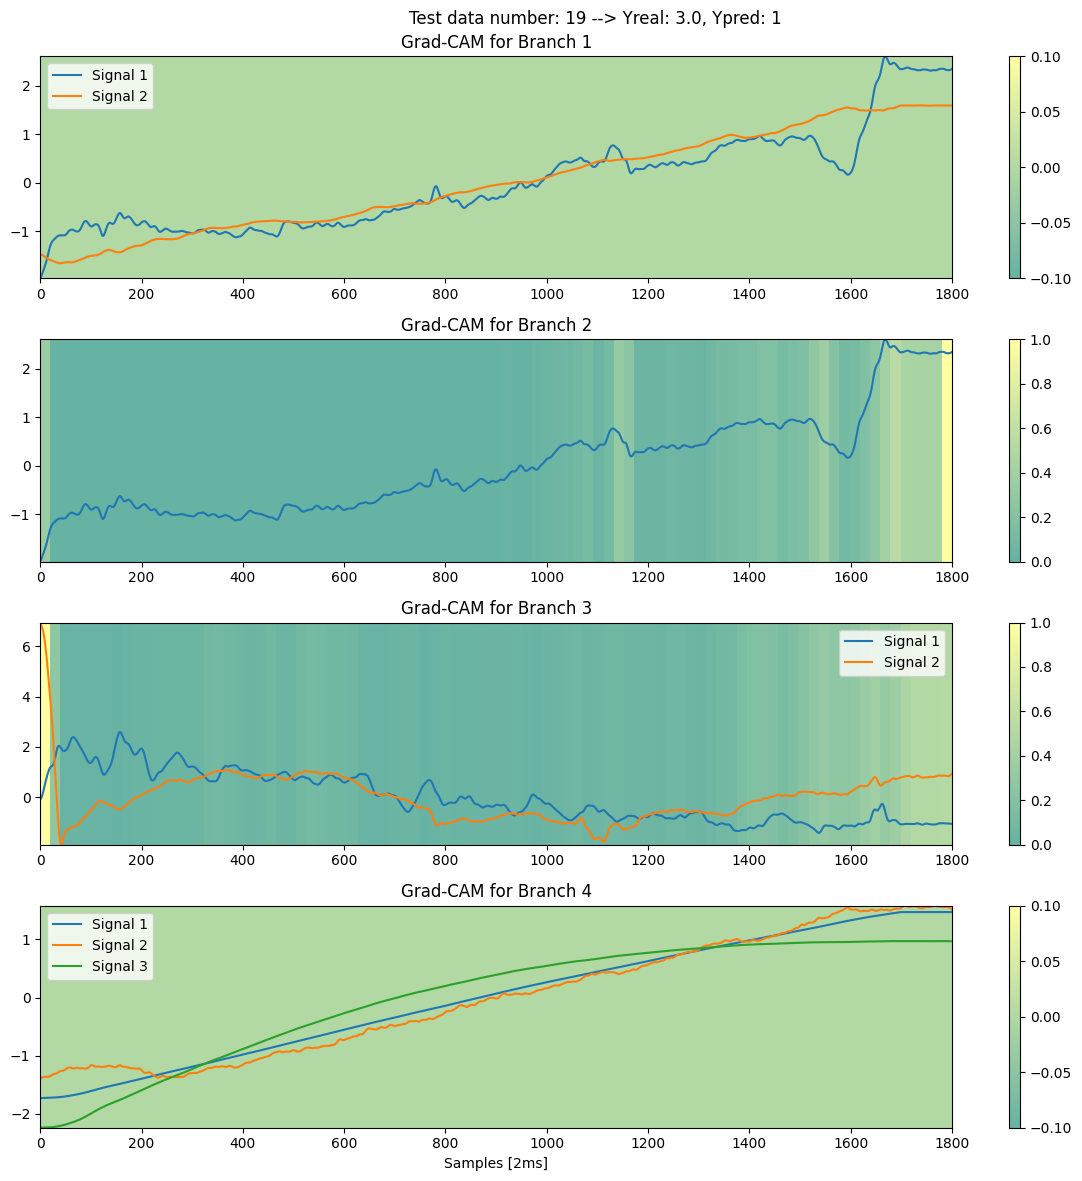

In [5]:
plot_grad_cam(model, [X_test1, X_test2, X_test3, X_test4], 19, y_test, ['conv1d_1_2', 'conv1d_2_2', 'conv1d_3_2', 'conv1d_4_2'])

# 3ConvLayers FirstTry: FxFzTy + Tz + FyTx

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 1800, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input2 (InputLayer) │ (None, 1800, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input3 (InputLayer) │ (None, 1800, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input4 (InputLayer) │ (None, 1800, 3)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_1 (Conv1D) │ (None, 180, 128)  │     10,368 │ input1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_1 (Conv1D) │ (None, 180, 128)  │      5,248 │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_1 (Conv1D) │ (None, 180, 128)  │     10,368 │ input3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_1 (Conv1D) │ (None, 180, 128)  │     15,488 │ input4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_2 (Conv1D) │ (None, 87, 256)   │    262,400 │ conv1d_1_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_2 (Conv1D) │ (None, 87, 256)   │    262,400 │ conv1d_2_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_2 (Conv1D) │ (None, 87, 256)   │    262,400 │ conv1d_3_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_2 (Conv1D) │ (None, 87, 256)   │    262,400 │ conv1d_4_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1_1         │ (None, 87, 256)   │          0 │ conv1d_1_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2_1         │ (None, 87, 256)   │          0 │ conv1d_2_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3_1         │ (None, 87, 256)   │          0 │ conv1d_3_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4_1         │ (None, 87, 256)   │          0 │ conv1d_4_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_3 (Conv1D) │ (None, 86, 512)   │    262,656 │ dropout_1_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_3 (Conv1D) │ (None, 86, 128)   │     65,664 │ dropout_2_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_3 (Conv1D) │ (None, 86, 512)   │    262,656 │ dropout_3_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_3 (Conv1D) │ (None, 86, 128)   │     65,664 │ dropout_4_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_1_1           │ (None, 512)       │          0 │ conv1d_1_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_2_1           │ (None, 128)       │          0 │ conv1d_2_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                 

 Total params: 1,829,956 (6.98 MB)

 Trainable params: 1,829,956 (6.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 448ms/step - accuracy: 0.3928 - loss: 1.3078 - val_accuracy: 0.6989 - val_loss: 0.8855
Epoch 2/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7193 - loss: 0.7567 - val_accuracy: 0.8387 - val_loss: 0.6484
Epoch 3/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7966 - loss: 0.5616 - val_accuracy: 0.8387 - val_loss: 0.5107
Epoch 4/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7916 - loss: 0.4987 - val_accuracy: 0.8280 - val_loss: 0.5443
Epoch 5/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7352 - loss: 0.6733 - val_accuracy: 0.8387 - val_loss: 0.4977
Epoch 6/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8475 - loss: 0.4124 - val_accuracy: 0.7527 - val_loss: 0.6322
Epoch 7/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8515 - loss: 0.4084 - val_accuracy: 0.7849 - val_loss: 0.5236
Epoch 8/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8612 - loss: 0.3857 - val_accuracy: 0.8602 - val_loss: 0.4416
Epoch 

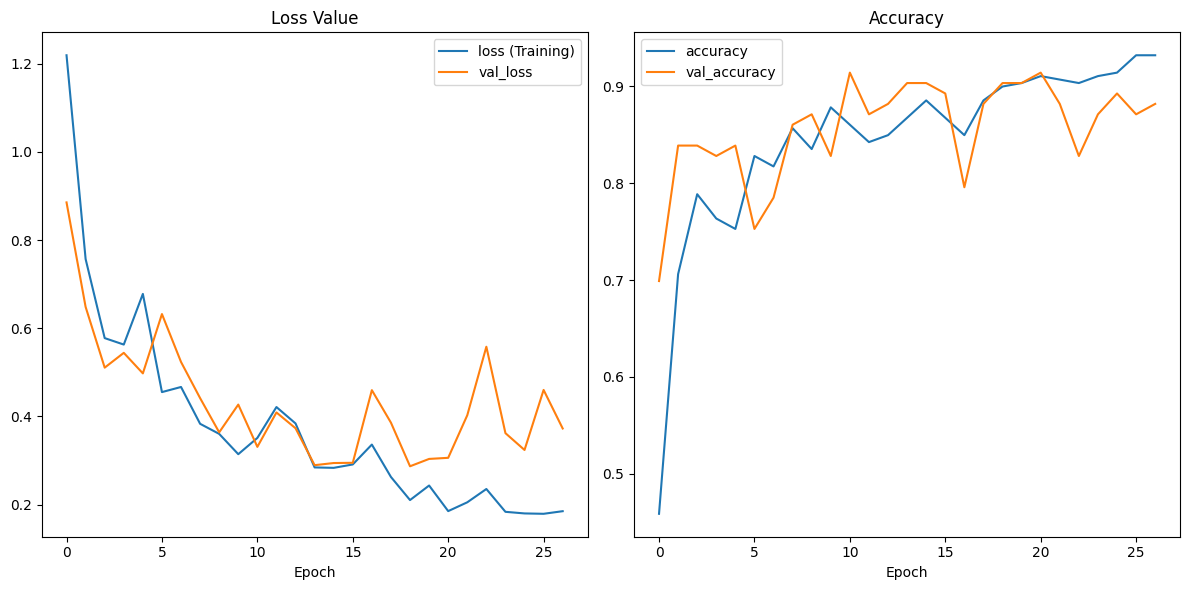

Test loss: 0.2117432802915573
Test accuracy: 0.9139784946236559
F1 Score: 0.8998128342245989
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        29
         1.0       0.95      0.95      0.95        22
         2.0       0.79      1.00      0.88        22
         3.0       0.93      0.65      0.76        20

    accuracy                           0.91        93
   macro avg       0.92      0.90      0.90        93
weighted avg       0.92      0.91      0.91        93



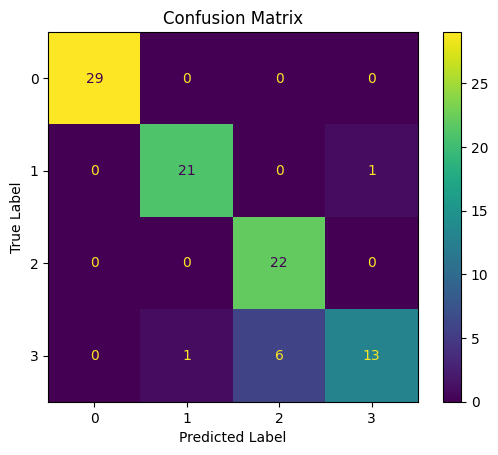

In [6]:
FILTN = 2
def build_branched_model(input_shape1, input_shape2, input_shape3, input_shape4):
    # First input branch
    input1 = Input(shape=input_shape1, name='input1')
    x1 = Conv1D(filters=64*FILTN, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_1_1')(input1)
    x1 = Conv1D(filters=128*FILTN, kernel_size=8, strides=2, activation='relu', name='conv1d_1_2')(x1)
    x1 = Dropout(rate=0.2, name='dropout_1_1')(x1)
    x1 = Conv1D(filters=256*FILTN, kernel_size=2, strides=1, activation='relu', name='conv1d_1_3')(x1)
    x1 = GlobalMaxPooling1D(name='gap1d_1_1')(x1)
    
    # Second input branch
    input2 = Input(shape=input_shape2, name='input2')
    x2 = Conv1D(filters=64*FILTN, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_2_1')(input2)
    x2 = Conv1D(filters=128*FILTN, kernel_size=8, strides=2, activation='relu', name='conv1d_2_2')(x2)
    x2 = Dropout(rate=0.2, name='dropout_2_1')(x2)
    x2 = Conv1D(filters=64*FILTN, kernel_size=2, strides=1, activation='relu', name='conv1d_2_3')(x2)
    x2 = GlobalMaxPooling1D(name='gap1d_2_1')(x2)
    
    # Third input branch
    input3 = Input(shape=input_shape3, name='input3')
    x3 = Conv1D(filters=64*FILTN, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_3_1')(input3)
    x3 = Conv1D(filters=128*FILTN, kernel_size=8, strides=2, activation='relu', name='conv1d_3_2')(x3)
    x3 = Dropout(rate=0.2, name='dropout_3_1')(x3)
    x3 = Conv1D(filters=256*FILTN, kernel_size=2, strides=1, activation='relu', name='conv1d_3_3')(x3)
    x3 = GlobalMaxPooling1D(name='gap1d_3_1')(x3)
    
    # Fourth input branch
    input4 = Input(shape=input_shape4, name='input4')
    x4 = Conv1D(filters=64*FILTN, kernel_size=40, strides=10, activation='relu', padding='same', name='conv1d_4_1')(input4)
    x4 = Conv1D(filters=128*FILTN, kernel_size=8, strides=2, activation='relu', name='conv1d_4_2')(x4)
    x4 = Dropout(rate=0.2, name='dropout_4_1')(x4)
    x4 = Conv1D(filters=64*FILTN, kernel_size=2, strides=1, activation='relu', name='conv1d_4_3')(x4)
    x4 = GlobalMaxPooling1D(name='gap1d_4_1')(x4)
    
    # Concatenate the outputs of the four branches
    merged = concatenate([x1, x2, x3, x4], name='concatenate_1')
    
    # Dense layers
    dense = Dense(64, activation='relu', name='dense_1')(merged)
    #dense = Dense(16, activation='relu', name='dense_2')(dense)
    
    # Output layer for 6-class classification
    output = Dense(OUT_N, activation='softmax', name='output')(dense)
    
    model = Model(inputs=[input1, input2, input3, input4], outputs=output)
    return model


# Create and compile the model
model = build_branched_model(input_shape1, input_shape2, input_shape3, input_shape4)
model.summary()

X_train = [X_train1, X_train2, X_train3, X_train4]
X_val   = [X_val1, X_val2, X_val3, X_val4]
X_test  = [X_test1, X_test2, X_test3, X_test4]

history, loss, accuracy, f1, y_pred_labels = compile_train_evaluate_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=70, batch_size=32, patience=8, disp_labels=DISP_LABELS)

In [7]:
# model_name = "MOD_AUG_KNOB_3Cnv_128Dens_400WideKern_96"
# save_datasummary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_branched_model, assign_and_deploy_variables)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


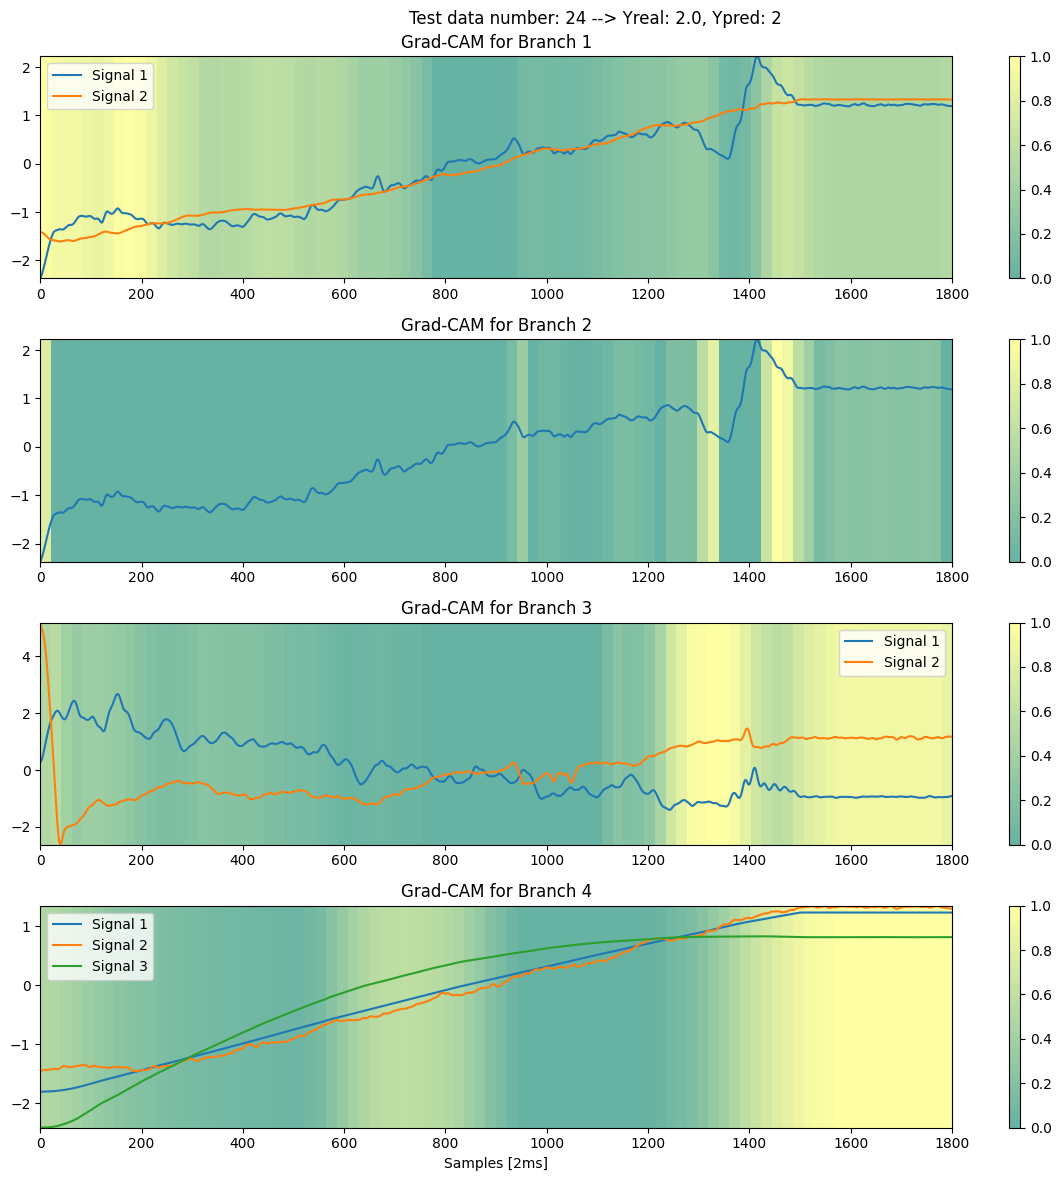

In [8]:
plot_grad_cam(model, [X_test1, X_test2, X_test3, X_test4], 24, y_test, ['conv1d_1_3', 'conv1d_2_3', 'conv1d_3_3', 'conv1d_4_3'])

# 3Conv 93% acheived

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 1800, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input2 (InputLayer) │ (None, 1800, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input3 (InputLayer) │ (None, 1800, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input4 (InputLayer) │ (None, 1800, 3)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_1 (Conv1D) │ (None, 90, 128)   │     10,368 │ input1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_1 (Conv1D) │ (None, 90, 128)   │      5,248 │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_1 (Conv1D) │ (None, 90, 128)   │     10,368 │ input3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_1 (Conv1D) │ (None, 90, 128)   │     15,488 │ input4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool1d_1_1       │ (None, 45, 128)   │          0 │ conv1d_1_1[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool1d_2_1       │ (None, 45, 128)   │          0 │ conv1d_2_1[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool1d_3_1       │ (None, 45, 128)   │          0 │ conv1d_3_1[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ maxpool1d_4_1       │ (None, 45, 128)   │          0 │ conv1d_4_1[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_2 (Conv1D) │ (None, 10, 256)   │    262,400 │ maxpool1d_1_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_2 (Conv1D) │ (None, 10, 256)   │    262,400 │ maxpool1d_2_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_2 (Conv1D) │ (None, 10, 256)   │    262,400 │ maxpool1d_3_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_2 (Conv1D) │ (None, 10, 256)   │    262,400 │ maxpool1d_4_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1_1         │ (None, 10, 256)   │          0 │ conv1d_1_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2_1         │ (None, 10, 256)   │          0 │ conv1d_2_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3_1         │ (None, 10, 256)   │          0 │ conv1d_3_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4_1         │ (None, 10, 256)   │          0 │ conv1d_4_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_3 (Conv1D) │ (None, 9, 256)    │    131,328 │ dropout_1_1[0][0

 Total params: 1,460,676 (5.57 MB)

 Trainable params: 1,460,676 (5.57 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 475ms/step - accuracy: 0.4222 - loss: 1.2457 - val_accuracy: 0.7312 - val_loss: 0.7148
Epoch 2/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7736 - loss: 0.6609 - val_accuracy: 0.8817 - val_loss: 0.3971
Epoch 3/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7830 - loss: 0.5765 - val_accuracy: 0.7634 - val_loss: 0.5011
Epoch 4/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7857 - loss: 0.5209 - val_accuracy: 0.8387 - val_loss: 0.4286
Epoch 5/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8554 - loss: 0.3909 - val_accuracy: 0.9032 - val_loss: 0.3029
Epoch 6/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8645 - loss: 0.3104 - val_accuracy: 0.8925 - val_loss: 0.3027
Epoch 7/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8471 - loss: 0.3546 - val_accuracy: 0.8925 - val_loss: 0.3837
Epoch 8/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8668 - loss: 0.3097 - val_accuracy: 0.8817 - val_loss: 0.3058
Epoch 9/70
9/9 ━━

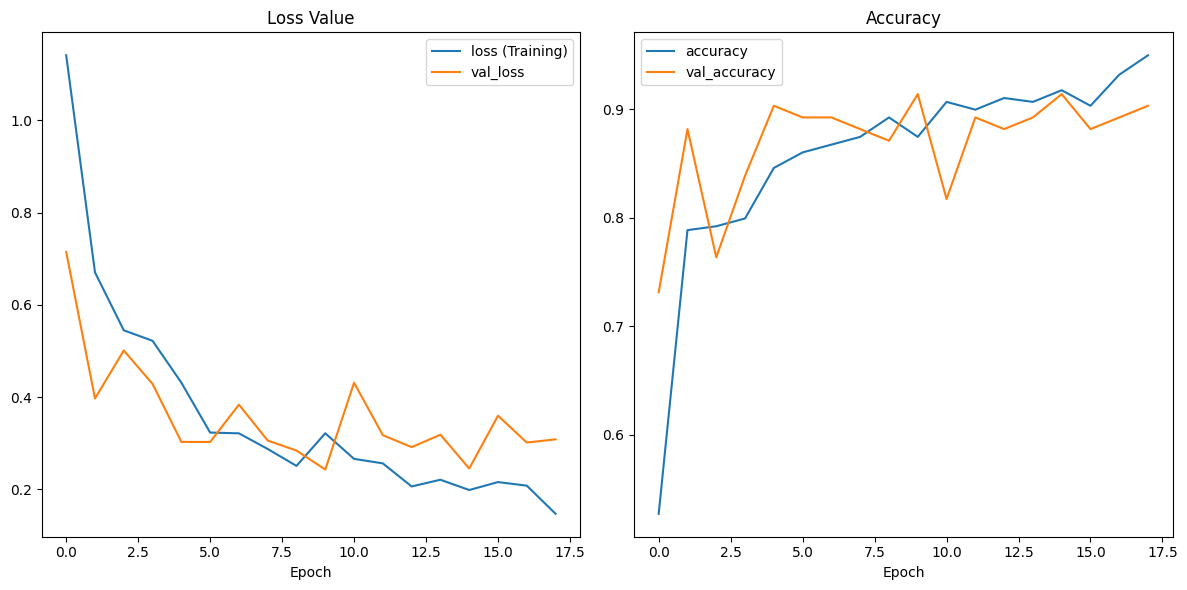

Test loss: 0.1548701673746109
Test accuracy: 0.9354838709677419
F1 Score: 0.9289082687338501
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        29
         1.0       1.00      0.95      0.98        22
         2.0       0.87      0.91      0.89        22
         3.0       0.85      0.85      0.85        20

    accuracy                           0.94        93
   macro avg       0.93      0.93      0.93        93
weighted avg       0.94      0.94      0.94        93



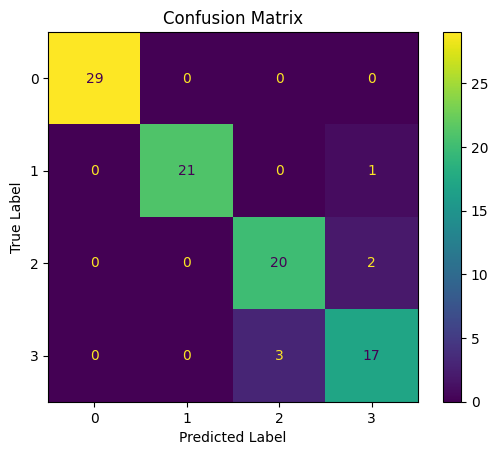

In [9]:
def build_branched_model(input_shape1, input_shape2, input_shape3, input_shape4):
    # First input branch
    input1 = Input(shape=input_shape1, name='input1')
    x1 = Conv1D(filters=128, kernel_size=40, strides=20, activation='relu', padding='same', name='conv1d_1_1')(input1)
    x1 = MaxPooling1D(pool_size=2, name='maxpool1d_1_1')(x1)
    x1 = Conv1D(filters=256, kernel_size=8, strides=4, activation='relu', name='conv1d_1_2')(x1)
    x1 = Dropout(rate=0.2, name='dropout_1_1')(x1)
    x1 = Conv1D(filters=256, kernel_size=2, strides=1, activation='relu', name='conv1d_1_3')(x1)
    x1 = GlobalMaxPooling1D(name='gap1d_1_1')(x1)
    
    # Second input branch
    input2 = Input(shape=input_shape2, name='input2')
    x2 = Conv1D(filters=128, kernel_size=40, strides=20, activation='relu', padding='same', name='conv1d_2_1')(input2)
    x2 = MaxPooling1D(pool_size=2, name='maxpool1d_2_1')(x2)
    x2 = Conv1D(filters=256, kernel_size=8, strides=4, activation='relu', name='conv1d_2_2')(x2)
    x2 = Dropout(rate=0.2, name='dropout_2_1')(x2)
    x2 = Conv1D(filters=64, kernel_size=2, strides=1, activation='relu', name='conv1d_2_3')(x2)
    x2 = GlobalMaxPooling1D(name='gap1d_2_1')(x2)
    
    # Third input branch
    input3 = Input(shape=input_shape3, name='input3')
    x3 = Conv1D(filters=128, kernel_size=40, strides=20, activation='relu', padding='same', name='conv1d_3_1')(input3)
    x3 = MaxPooling1D(pool_size=2, name='maxpool1d_3_1')(x3)
    x3 = Conv1D(filters=256, kernel_size=8, strides=4, activation='relu', name='conv1d_3_2')(x3)
    x3 = Dropout(rate=0.2, name='dropout_3_1')(x3)
    x3 = Conv1D(filters=256, kernel_size=2, strides=1, activation='relu', name='conv1d_3_3')(x3)
    x3 = GlobalMaxPooling1D(name='gap1d_3_1')(x3)
    
    # Fourth input branch
    input4 = Input(shape=input_shape4, name='input4')
    x4 = Conv1D(filters=128, kernel_size=40, strides=20, activation='relu', padding='same', name='conv1d_4_1')(input4)
    x4 = MaxPooling1D(pool_size=2, name='maxpool1d_4_1')(x4)
    x4 = Conv1D(filters=256, kernel_size=8, strides=4, activation='relu', name='conv1d_4_2')(x4)
    x4 = Dropout(rate=0.2, name='dropout_4_1')(x4)
    x4 = Conv1D(filters=64, kernel_size=2, strides=1, activation='relu', name='conv1d_4_3')(x4)
    x4 = GlobalMaxPooling1D(name='gap1d_4_1')(x4)
    
    # Concatenate the outputs of the four branches
    merged = concatenate([x1, x2, x3, x4], name='concatenate_1')
    
    # Dense layers
    dense = Dense(64, activation='relu', name='dense_1')(merged)
    #dense = Dense(32, activation='relu', name='dense_2')(dense)
    
    # Output layer for 4-class classification
    output = Dense(OUT_N, activation='softmax', name='output')(dense)
    
    model = Model(inputs=[input1, input2, input3, input4], outputs=output)
    return model

# Create and compile the model
model = build_branched_model(input_shape1, input_shape2, input_shape3, input_shape4)
model.summary()

X_train = [X_train1, X_train2, X_train3, X_train4]
X_val   = [X_val1, X_val2, X_val3, X_val4]
X_test  = [X_test1, X_test2, X_test3, X_test4]

history, loss, accuracy, f1, y_pred_labels = compile_train_evaluate_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=70, batch_size=32, patience=8, disp_labels=DISP_LABELS)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


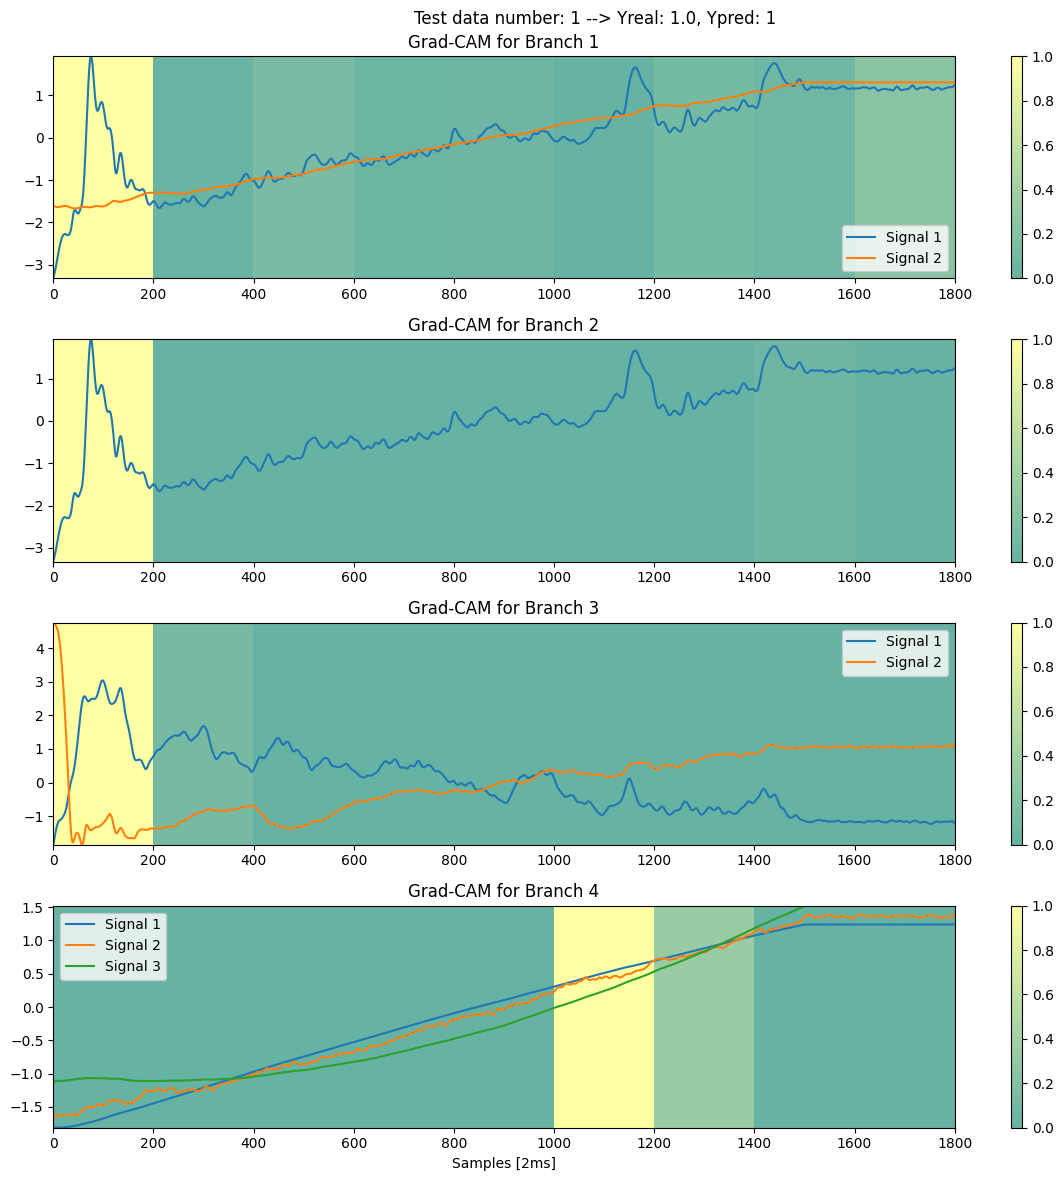

In [10]:
plot_grad_cam(model, [X_test1, X_test2, X_test3, X_test4], 1, y_test, ['conv1d_1_3', 'conv1d_2_3', 'conv1d_3_3', 'conv1d_4_3'])

In [11]:
# model_name = "MOD_AUG_KNOB_3Cnv_128Dens_400WideKern_96"
# save_datasummary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_branched_model, assign_and_deploy_variables)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

# 4 ConvLayers

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 1800, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input2 (InputLayer) │ (None, 1800, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input3 (InputLayer) │ (None, 1800, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input4 (InputLayer) │ (None, 1800, 3)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_0 (Conv1D) │ (None, 90, 256)   │     51,456 │ input1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_0 (Conv1D) │ (None, 90, 256)   │     25,856 │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_0 (Conv1D) │ (None, 90, 256)   │     51,456 │ input3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_0 (Conv1D) │ (None, 90, 256)   │     77,056 │ input4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_1 (Conv1D) │ (None, 10, 256)   │  1,048,832 │ conv1d_1_0[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_1 (Conv1D) │ (None, 10, 256)   │  1,048,832 │ conv1d_2_0[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_1 (Conv1D) │ (None, 10, 256)   │  1,048,832 │ conv1d_3_0[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_1 (Conv1D) │ (None, 10, 256)   │  1,048,832 │ conv1d_4_0[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_2 (Conv1D) │ (None, 2, 512)    │  1,049,088 │ conv1d_1_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_2 (Conv1D) │ (None, 2, 256)    │    524,544 │ conv1d_2_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_2 (Conv1D) │ (None, 2, 512)    │  1,049,088 │ conv1d_3_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_2 (Conv1D) │ (None, 2, 256)    │    524,544 │ conv1d_4_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1_1         │ (None, 2, 512)    │          0 │ conv1d_1_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2_1         │ (None, 2, 256)    │          0 │ conv1d_2_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3_1         │ (None, 2, 512)    │          0 │ conv1d_3_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4_1         │ (None, 2, 256)    │          0 │ conv1d_4_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_3 (Conv1D) │ (None, 1, 512)    │    524,800 │ dropout_1_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_3 (Conv1D) │ (None, 1, 256)    │    131,328 │ dropout_2_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_3 (Conv1D) │ (None, 1, 512)    │    524,800 │ dropout_3_1[0][0

 Total params: 8,885,574 (33.90 MB)

 Trainable params: 8,885,574 (33.90 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 623ms/step - accuracy: 0.2457 - loss: 1.5351 - val_accuracy: 0.6774 - val_loss: 0.8460
Epoch 2/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6201 - loss: 0.8416 - val_accuracy: 0.8065 - val_loss: 0.4852
Epoch 3/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7810 - loss: 0.5611 - val_accuracy: 0.9032 - val_loss: 0.3047
Epoch 4/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8561 - loss: 0.4463 - val_accuracy: 0.9140 - val_loss: 0.2260
Epoch 5/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8469 - loss: 0.4197 - val_accuracy: 0.9032 - val_loss: 0.2643
Epoch 6/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8510 - loss: 0.3677 - val_accuracy: 0.9032 - val_loss: 0.2848
Epoch 7/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8701 - loss: 0.3119 - val_accuracy: 0.8710 - val_loss: 0.3795
Epoch 8/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8901 - loss: 0.2880 - val_accuracy: 0.8925 - val_loss: 0.2782
Epoch

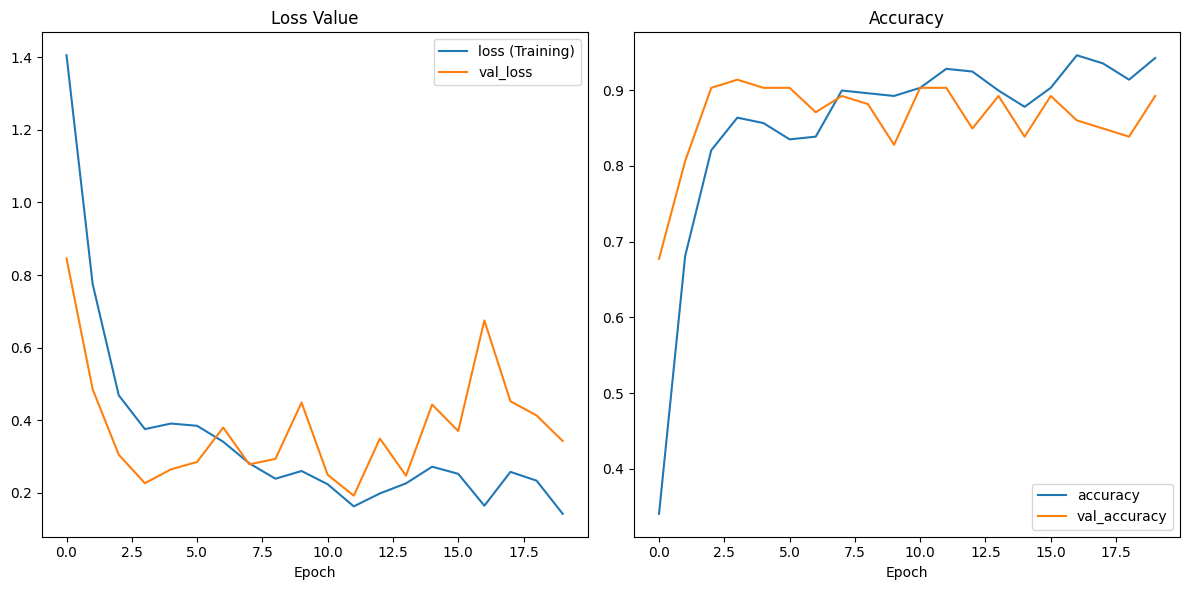

Test loss: 0.18749116361141205
Test accuracy: 0.9354838709677419
F1 Score: 0.9338118022328549
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.93      0.95        29
         1.0       0.95      0.95      0.95        22
         2.0       0.91      0.95      0.93        22
         3.0       0.90      0.90      0.90        20

    accuracy                           0.94        93
   macro avg       0.93      0.94      0.93        93
weighted avg       0.94      0.94      0.94        93



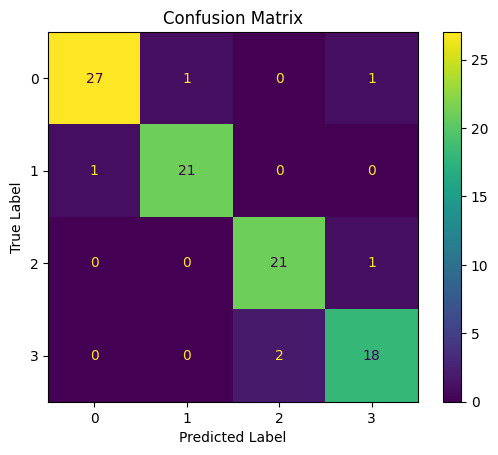

In [12]:
FILTN = 2
def build_branched_model(input_shape1, input_shape2, input_shape3, input_shape4):
    # First input branch
    input1 = Input(shape=input_shape1, name='input1')
    x1 = Conv1D(filters=128*FILTN, kernel_size=100, strides=20, activation='relu', padding='same', name='conv1d_1_0')(input1)
    x1 = Conv1D(filters=128*FILTN, kernel_size=16, strides=8, activation='relu', name='conv1d_1_1')(x1)
    x1 = Conv1D(filters=256*FILTN, kernel_size=8, strides=2, activation='relu', name='conv1d_1_2')(x1)
    x1 = Dropout(rate=0.2, name='dropout_1_1')(x1)
    x1 = Conv1D(filters=256*FILTN, kernel_size=2, strides=1, activation='relu', name='conv1d_1_3')(x1)
    x1 = GlobalMaxPooling1D(name='gap1d_1_1')(x1)

    # Second input branch
    input2 = Input(shape=input_shape2, name='input2')
    x2 = Conv1D(filters=128*FILTN, kernel_size=100, strides=20, activation='relu', padding='same', name='conv1d_2_0')(input2)
    x2 = Conv1D(filters=128*FILTN, kernel_size=16, strides=8, activation='relu', name='conv1d_2_1')(x2)
    x2 = Conv1D(filters=128*FILTN, kernel_size=8, strides=2, activation='relu', name='conv1d_2_2')(x2)
    x2 = Dropout(rate=0.2, name='dropout_2_1')(x2)
    x2 = Conv1D(filters=128*FILTN, kernel_size=2, strides=1, activation='relu', name='conv1d_2_3')(x2)
    x2 = GlobalMaxPooling1D(name='gap1d_2_1')(x2)

    # Third input branch
    input3 = Input(shape=input_shape3, name='input3')
    x3 = Conv1D(filters=128*FILTN, kernel_size=100, strides=20, activation='relu', padding='same', name='conv1d_3_0')(input3)
    x3 = Conv1D(filters=128*FILTN, kernel_size=16, strides=8, activation='relu', name='conv1d_3_1')(x3)
    x3 = Conv1D(filters=256*FILTN, kernel_size=8, strides=2, activation='relu', name='conv1d_3_2')(x3)
    x3 = Dropout(rate=0.2, name='dropout_3_1')(x3)
    x3 = Conv1D(filters=256*FILTN, kernel_size=2, strides=1, activation='relu', name='conv1d_3_3')(x3)
    x3 = GlobalMaxPooling1D(name='gap1d_3_1')(x3)

    # Fourth input branch
    input4 = Input(shape=input_shape4, name='input4')
    x4 = Conv1D(filters=128*FILTN, kernel_size=100, strides=20, activation='relu', padding='same', name='conv1d_4_0')(input4)
    x4 = Conv1D(filters=128*FILTN, kernel_size=16, strides=8, activation='relu', name='conv1d_4_1')(x4)
    x4 = Conv1D(filters=128*FILTN, kernel_size=8, strides=2, activation='relu', name='conv1d_4_2')(x4)
    x4 = Dropout(rate=0.2, name='dropout_4_1')(x4)
    x4 = Conv1D(filters=64*FILTN, kernel_size=2, strides=1, activation='relu', name='conv1d_4_3')(x4)
    x4 = GlobalMaxPooling1D(name='gap1d_4_1')(x4)

    # Concatenate the outputs of the four branches
    merged = concatenate([x1, x2, x3, x4], name='concatenate_1')

    # Dense layers
    dense = Dense(64, activation='relu', name='dense_1')(merged)
    #dense = Dense(16, activation='relu', name='dense_2')(dense)

    # Output layer for 6-class classification
    output = Dense(6, activation='softmax', name='output')(dense)

    # Create the model
    model = Model(inputs=[input1, input2, input3, input4], outputs=output)

    return model

# Create and compile the model
model = build_branched_model(input_shape1, input_shape2, input_shape3, input_shape4)
model.summary()

X_train = [X_train1, X_train2, X_train3, X_train4]
X_val   = [X_val1, X_val2, X_val3, X_val4]
X_test  = [X_test1, X_test2, X_test3, X_test4]

history, loss, accuracy, f1, y_pred_labels = compile_train_evaluate_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=70, batch_size=32, patience=8, disp_labels=DISP_LABELS)

In [13]:
# model_name = "1D_LD_4Cnv_1Dens_100W_20S_97"
# save_datasummary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_branched_model, assign_and_deploy_variables)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

y_pred: 0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


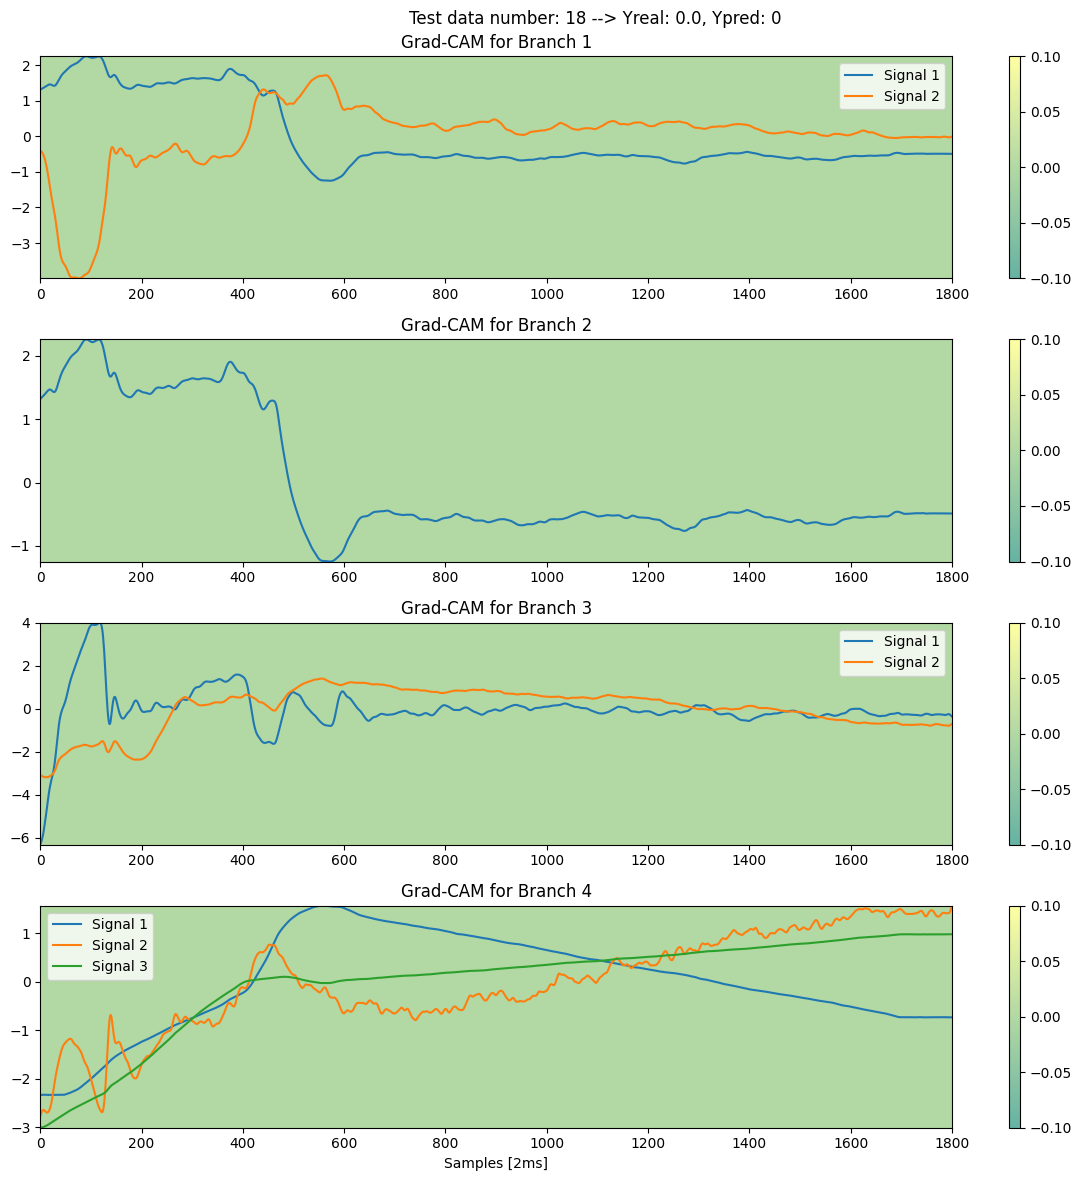

In [14]:
print(f"y_pred: {y_pred_labels[18]}")
plot_grad_cam(model, [X_test1, X_test2, X_test3, X_test4], 18, y_test, ['conv1d_1_3', 'conv1d_2_3', 'conv1d_3_3', 'conv1d_4_3'])

# same as best EASY f+f but branched

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 1800, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input2 (InputLayer) │ (None, 1800, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input3 (InputLayer) │ (None, 1800, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input4 (InputLayer) │ (None, 1800, 3)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_1 (Conv1D) │ (None, 446, 64)   │      2,624 │ input1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_1 (Conv1D) │ (None, 446, 64)   │      1,344 │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_1 (Conv1D) │ (None, 446, 64)   │      2,624 │ input3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_1 (Conv1D) │ (None, 446, 64)   │      3,904 │ input4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 223, 64)   │          0 │ conv1d_1_1[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 223, 64)   │          0 │ conv1d_2_1[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 223, 64)   │          0 │ conv1d_3_1[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 223, 64)   │          0 │ conv1d_4_1[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_2 (Conv1D) │ (None, 52, 128)   │    131,200 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_2 (Conv1D) │ (None, 52, 128)   │    131,200 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_2 (Conv1D) │ (None, 52, 128)   │    131,200 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4_2 (Conv1D) │ (None, 52, 128)   │    131,200 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 52, 128)   │          0 │ conv1d_1_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 52, 128)   │          0 │ conv1d_2_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 52, 128)   │          0 │ conv1d_3_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 52, 128)   │          0 │ conv1d_4_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_3 (Conv1D) │ (None, 45, 128)   │    131,200 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_3 (Conv1D) │ (None, 45, 128)   │    131,200 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_3 (Conv1D) │ (None, 45, 128)   │    131,200 │ dropout_2[0][0] 

 Total params: 1,429,700 (5.45 MB)

 Trainable params: 1,429,700 (5.45 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70


9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 486ms/step - accuracy: 0.2622 - loss: 1.3626 - val_accuracy: 0.6129 - val_loss: 1.0337
Epoch 2/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6797 - loss: 0.8387 - val_accuracy: 0.7204 - val_loss: 0.7395
Epoch 3/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7935 - loss: 0.6316 - val_accuracy: 0.6237 - val_loss: 0.8578
Epoch 4/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7075 - loss: 0.6378 - val_accuracy: 0.7204 - val_loss: 0.6223
Epoch 5/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7959 - loss: 0.5418 - val_accuracy: 0.8495 - val_loss: 0.3751
Epoch 6/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8142 - loss: 0.5086 - val_accuracy: 0.7527 - val_loss: 0.7364
Epoch 7/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8235 - loss: 0.4402 - val_accuracy: 0.7849 - val_loss: 0.4617
Epoch 8/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8773 - loss: 0.3446 - val_accuracy: 0.8602 - val_loss: 0.3162
Epoch 9/70
9/9 ━━

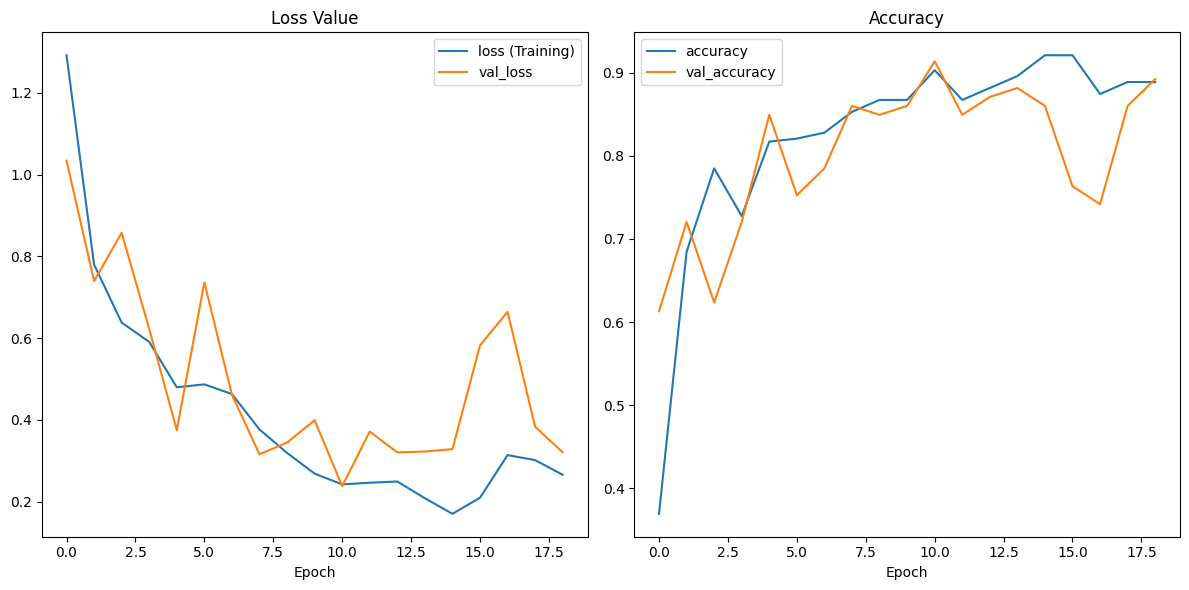

Test loss: 0.1837860643863678
Test accuracy: 0.956989247311828
F1 Score: 0.9519450800915332
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        29
         1.0       1.00      1.00      1.00        22
         2.0       0.88      0.95      0.91        22
         3.0       0.94      0.85      0.89        20

    accuracy                           0.96        93
   macro avg       0.95      0.95      0.95        93
weighted avg       0.96      0.96      0.96        93



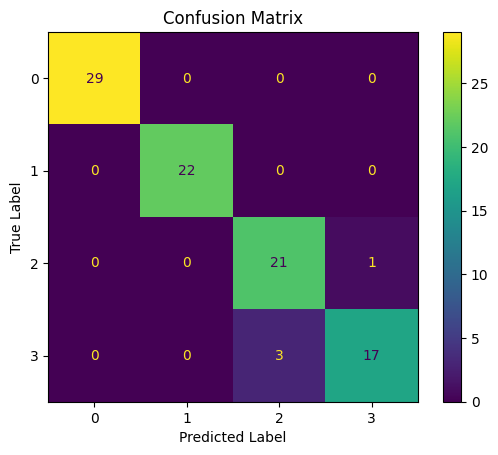

In [15]:
def build_branched_model(input_shape1, input_shape2, input_shape3, input_shape4):
    # First input branch
    input1 = Input(shape=input_shape1, name='input1')
    x1 = Conv1D(filters=64, kernel_size=20, strides=4, activation='relu', name='conv1d_1_1')(input1)
    x1 = MaxPooling1D(pool_size=2)(x1)
    x1 = Conv1D(filters=128, kernel_size=16, strides=4, activation='relu', name='conv1d_1_2')(x1)
    x1 = Dropout(rate=0.1)(x1)
    x1 = Conv1D(filters=128, kernel_size=8, activation='relu', name='conv1d_1_3')(x1)
    x1 = MaxPooling1D(pool_size=2)(x1)
    x1 = Conv1D(filters=256, kernel_size=4, activation='relu', name='conv1d_1_4')(x1)
    x1 = GlobalMaxPooling1D(name='gap1d_1_1')(x1)
    
    # Second input branch
    input2 = Input(shape=input_shape2, name='input2')
    x2 = Conv1D(filters=64, kernel_size=20, strides=4, activation='relu', name='conv1d_2_1')(input2)
    x2 = MaxPooling1D(pool_size=2)(x2)
    x2 = Conv1D(filters=128, kernel_size=16, strides=4, activation='relu', name='conv1d_2_2')(x2)
    x2 = Dropout(rate=0.1)(x2)
    x2 = Conv1D(filters=128, kernel_size=8, activation='relu', name='conv1d_2_3')(x2)
    x2 = MaxPooling1D(pool_size=2)(x2)
    x2 = Conv1D(filters=64, kernel_size=4, activation='relu', name='conv1d_2_4')(x2)
    x2 = GlobalMaxPooling1D(name='gap1d_2_1')(x2)
    
    # Third input branch
    input3 = Input(shape=input_shape3, name='input3')
    x3 = Conv1D(filters=64, kernel_size=20, strides=4, activation='relu', name='conv1d_3_1')(input3)
    x3 = MaxPooling1D(pool_size=2)(x3)
    x3 = Conv1D(filters=128, kernel_size=16, strides=4, activation='relu', name='conv1d_3_2')(x3)
    x3 = Dropout(rate=0.1)(x3)
    x3 = Conv1D(filters=128, kernel_size=8, activation='relu', name='conv1d_3_3')(x3)
    x3 = MaxPooling1D(pool_size=2)(x3)
    x3 = Conv1D(filters=256, kernel_size=4, activation='relu', name='conv1d_3_4')(x3)
    x3 = GlobalMaxPooling1D(name='gap1d_3_1')(x3)
    
    # Fourth input branch
    input4 = Input(shape=input_shape4, name='input4')
    x4 = Conv1D(filters=64, kernel_size=20, strides=4, activation='relu', name='conv1d_4_1')(input4)
    x4 = MaxPooling1D(pool_size=2)(x4)
    x4 = Conv1D(filters=128, kernel_size=16, strides=4, activation='relu', name='conv1d_4_2')(x4)
    x4 = Dropout(rate=0.1)(x4)
    x4 = Conv1D(filters=128, kernel_size=8, activation='relu', name='conv1d_4_3')(x4)
    x4 = MaxPooling1D(pool_size=2)(x4)
    x4 = Conv1D(filters=64, kernel_size=4, activation='relu', name='conv1d_4_4')(x4)
    x4 = GlobalMaxPooling1D(name='gap1d_4_1')(x4)
    
    # Concatenate the outputs of the four branches
    merged = concatenate([x1, x2, x3, x4], name='concatenate_1')
    
    # Dense layers
    dense = Dense(64, activation='relu', name='dense_1')(merged)
    #dense = Dense(16, activation='relu', name='dense_2')(dense)
    
    # Output layer for 4-class classification (adjust if needed)
    output = Dense(OUT_N, activation='softmax', name='output')(dense)
    
    model = Model(inputs=[input1, input2, input3, input4], outputs=output)
    return model

# Create and compile the model
model = build_branched_model(input_shape1, input_shape2, input_shape3, input_shape4)
model.summary()

X_train = [X_train1, X_train2, X_train3, X_train4]
X_val   = [X_val1, X_val2, X_val3, X_val4]
X_test  = [X_test1, X_test2, X_test3, X_test4]

history, loss, accuracy, f1, y_pred_labels = compile_train_evaluate_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=70, batch_size=32, patience=8, disp_labels=DISP_LABELS)

In [18]:
model_name = "1D_Comb_SPEED_TRANSF_96"
save_datasummary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_branched_model, assign_and_deploy_variables)
#model.save(f"{model_name}.h5")
from tensorflow.keras.models import save_model
save_dir = "saved_models/"
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, f"{model_name}.keras")
save_model(model, model_path)

y_pred: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


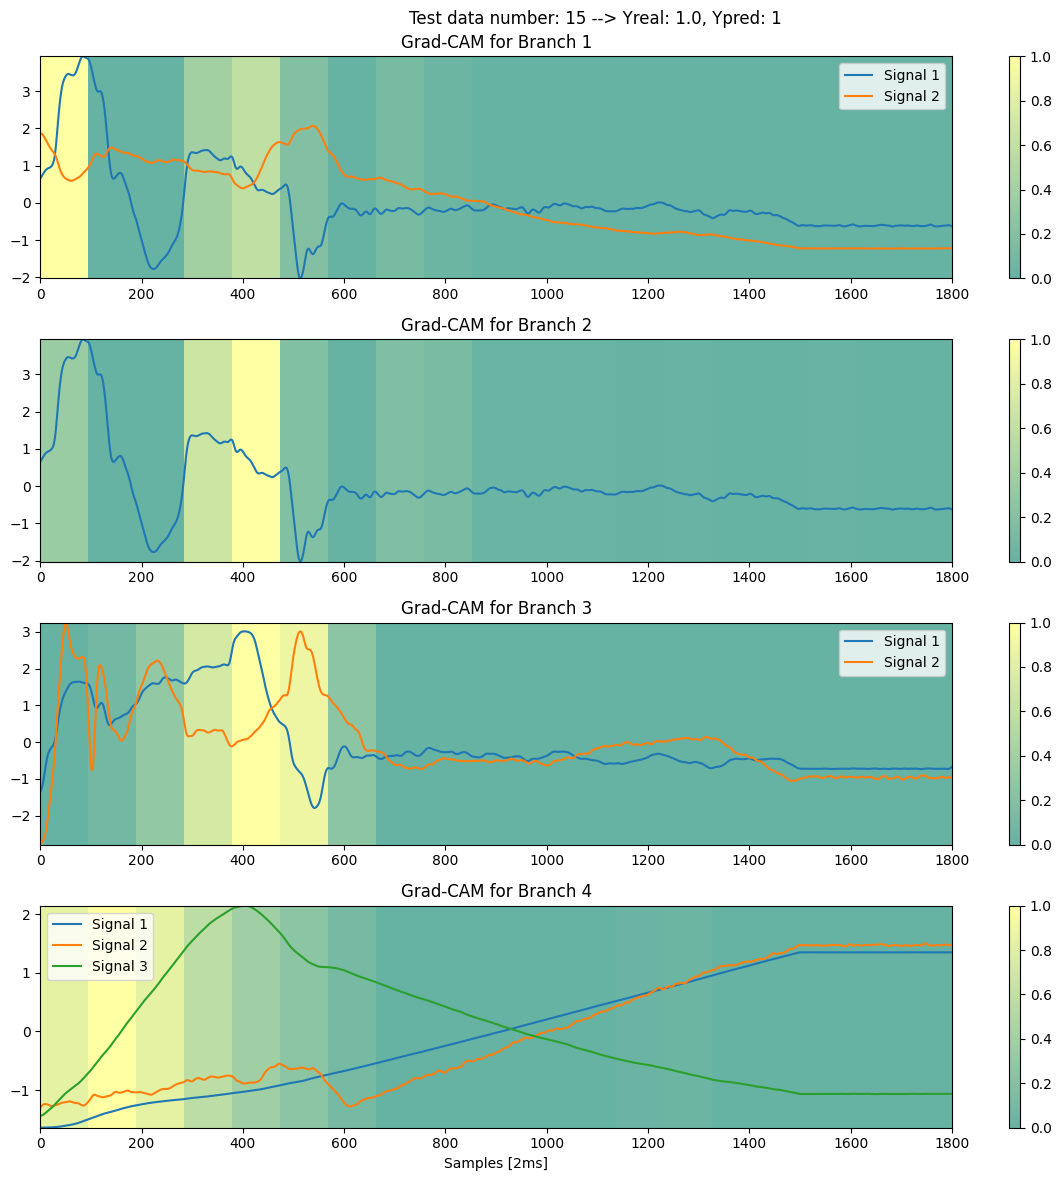

In [17]:
print(f"y_pred: {y_pred_labels[15]}")
plot_grad_cam(model, [X_test1, X_test2, X_test3, X_test4], 15, y_test, ['conv1d_1_4', 'conv1d_2_4', 'conv1d_3_4', 'conv1d_4_4'])